In [5]:
import numpy as np
from pylibs.plasma import plasma
from test1 import loadlines, levels

import matplotlib.pyplot as plt
plt.style.use( 'ggplot' )

In [25]:
lines = loadlines("percistent_lines.txt", ['cu', 'sn'] )

etree = {
            'cu': {
                    'm'      : 63.546,
                    'species': [
                                    {
                                        'Vs'    : 7.726380,
                                        'levels': levels('cu-1'),
                                        'lines' : lines,
                                    },
                                    {
                                        'Vs'    : 20.29239,
                                        'levels': levels('cu-2'),
                                        'lines' : lines,
                                    },
                            ]
                },
            'sn': {
                    'm'      : 118.710,
                    'species': [
                                    {
                                        'Vs'    : 7.343918,
                                        'levels': levels('sn-1'),
                                        'lines' : lines,
                                    },
                                    {
                                        'Vs'    : 14.63307,
                                        'levels': levels('sn-2'),
                                        'lines' : lines,
                                    }
                            ]
                },
        }

c = { 'cu': 'tab:blue', 'sn': 'green', }


copper_tin = plasma('copper_tin', etree)

a = copper_tin(70.0)

a.setup(1.0, 1.0E+17)

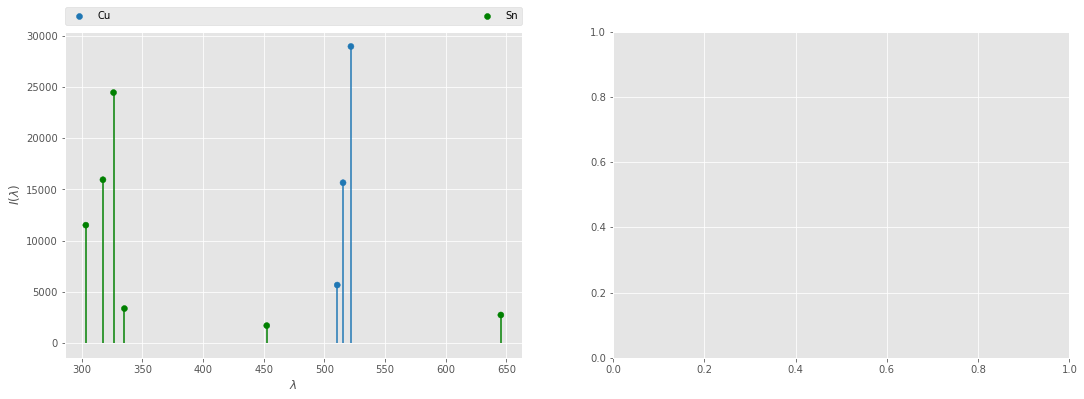

In [26]:
lnt = a.lines

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [18, 6])

ax1.scatter( lnt.wavelen, lnt.I, c = np.array([ c[x] for x in lnt.elem ]) )
ax1.vlines( lnt.wavelen, 0.0, lnt.I, colors = np.array([ c[x] for x in lnt.elem ]) )
ax1.scatter([], [], c = c['cu'], label = 'Cu')
ax1.scatter([], [], c = c['sn'], label = 'Sn')

ax1.legend(
                bbox_to_anchor = (0.0, 1.02, 1.0, 0.102),
                loc = 'lower left', ncol = 2,
                mode = 'expand', borderaxespad = 0,
          )
ax1.set( xlabel = '$\\lambda$', ylabel = '$I(\\lambda)$' )

plt.show()